In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

In [3]:
from gnnboundary import *

# COLLAB

In [4]:
dataset = CollabDataset(seed=12345)

Processing...
Done!


In [5]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=5)
model.load_state_dict(torch.load('ckpts/collab.pt'))

<All keys matched successfully>

In [6]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)
print(dataset_list_pred)


/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[CollabDataset(2681), CollabDataset(716), CollabDataset(1603)]


In [7]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.8528000116348267,
 'cm': array([[2297,  109,  194],
        [ 161,  586,   28],
        [ 223,   21, 1381]]),
 'f1': {'High Energy': 0.8699110150337219,
  'Condensed Matter': 0.7860496044158936,
  'Astro': 0.8556381464004517}}

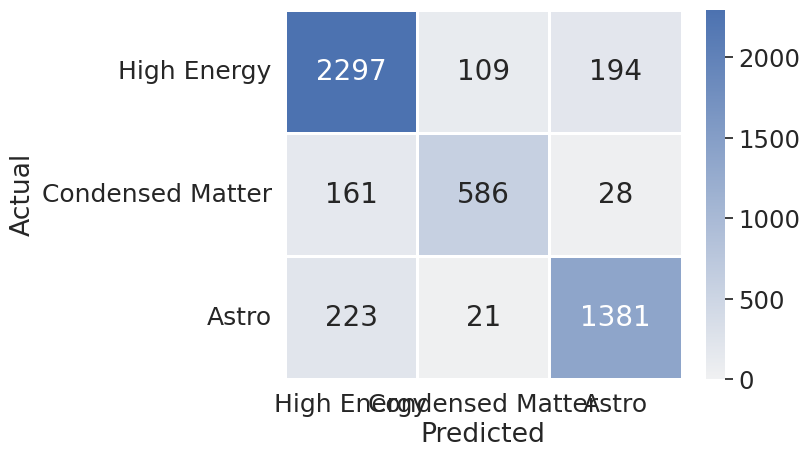

In [8]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [8]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

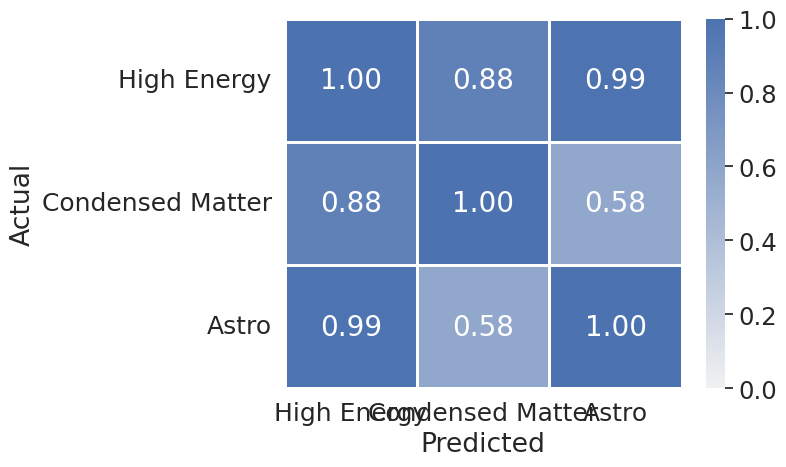

In [10]:
# This appears not to be deterministic

adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')


# vgm kijken ze naar deze adjecency graph. Als een waarde boven de threshold (0.75??) zit zijn de classes adjecent. 
# Daarna genereren ze hieronder de near-boundary graphs. Dit kan je ook zien aan dat de probs:
# probs=[0.579569399356842, 2.680641227925662e-05, 0.4204038083553314] maar bij 2 classes (waarvoor het genereerd is) een redelijke
# waarde heeft.

# het genereren hebben ze 500x gedaan en de mean+std van de probs genomen. Deze loop / stap ontbreekt in de code

# code voor de boundary thickness + margin + plots ontbreekt

In [9]:
trainer = {}
sampler = {}
from lib.trainer import GPUTrainer
from lib.trainer import NewTrainer

# 0 1 2

In [16]:
cls_1, cls_2, cls_3 = 0, 1, 2
trainer[cls_1, cls_2, cls_3] = NewTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2, cls_3], alpha=1, beta=2
        ), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_3]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    min_iteration=500
)

In [17]:
cls_1, cls_2, cls_3 = 0, 1, 2
p_min = 0.3
p_max = 0.366
trainer[cls_1, cls_2, cls_3].train(
    iterations=2000,
    target_probs={cls_1: (p_min, p_max), cls_2: (p_min, p_max), cls_3: (p_min, p_max)},
    target_size=150,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=32
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

logits=[0.4472673535346985, 0.2812173366546631, -0.31481391191482544]
probs=[0.43220850825309753, 0.3660822808742523, 0.20170916616916656]
n=22 m=48


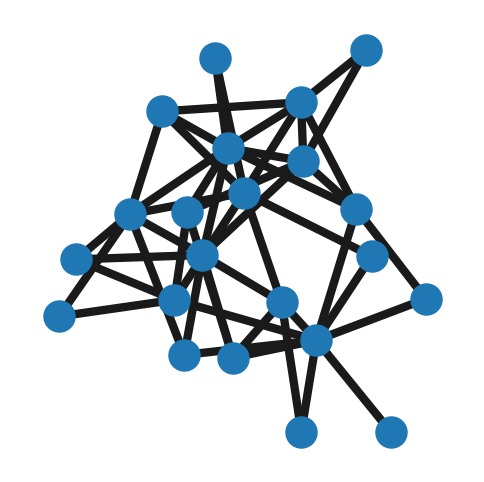

In [18]:
cls_1, cls_2, cls_3 = 0, 1, 2

trainer[cls_1, cls_2, cls_3].evaluate(threshold=0.5, show=True, bernoulli=True)

In [19]:
res = trainer[cls_1, cls_2, cls_3].quantitative(sample_size=500)
print(res["mean"])
print(res["std"])

[0.43510979 0.36490399 0.19998623]
[0.0481752  0.03805912 0.05511042]


# 0 & 1

In [80]:
from lib.trainer import TrainerGPU

cls_1, cls_2 = 0, 1
trainer[cls_1, cls_2] = TrainerGPU(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(classes=[cls_1, cls_2]), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [81]:
cls_1, cls_2 = 0, 1
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.45, 0.55), cls_2: (0.45, 0.55)},
    target_size=30,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

False

n=24 m=46
logits=[1.0117878913879395, 1.2232589721679688, -1.9432322978973389]
probs=[0.4371447265148163, 0.5400897860527039, 0.022765452042222023]


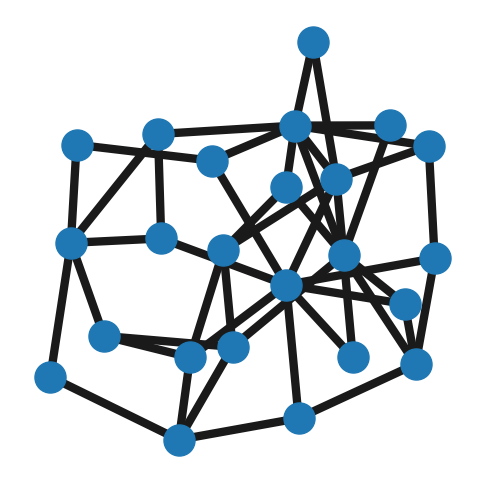

In [82]:
trainer[0, 1].evaluate(threshold=0.5, show=True)

In [ ]:
a = trainer[0, 1].quantitative(sample_size=1000)
# b = trainer[0, 1].quantitative_baseline()

print(a)
# print(b)

{'label': ['High Energy', 'Condensed Matter', 'Astro'], 'mean': array([0.48350861, 0.48423868, 0.03225271]), 'std': array([0.08027554, 0.08573632, 0.01664525])}


In [49]:
res = trainer[0,1].get_training_success_rate(5, 100)
print(res)

  0%|          | 0/5 [00:00<?, ?it/s]

[]


# 0 & 2

In [23]:
cls_1, cls_2 = 0, 2
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(classes=[cls_1, cls_2]), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1)
)

In [24]:
cls_1, cls_2 = 0, 2
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=30,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=24 m=18
logits=[0.34541505575180054, -6.833475112915039, -0.40399184823036194]
probs=[0.6786981225013733, 0.0005175165715627372, 0.32078447937965393]


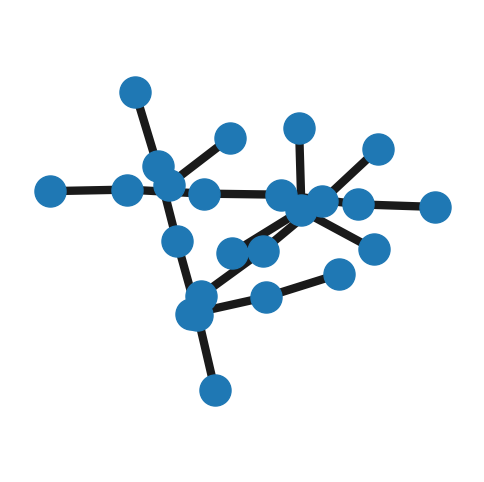

In [20]:
trainer[0, 2].evaluate(threshold=0.5, show=True)